In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from functools import wraps
from time import time
import numpy as np

"""pre-processing"""
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

#auxiliar
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [44]:
df = pd.read_csv("dataset.csv", sep=";", decimal=',')

#to plot graphs used for exploratory data analysis
mk_graphs = False

# to save tables and graphs(images) to be used on the article
save_tables = False
save_images = False
saved_format = "png"

# Fixing the data

In [3]:
#tradução nome dos solos
traducao = {
    'Clay':'Argila',
    'Sand':'Areia',
    'Mining tailing - bauxit': 'Rejeito de Mineração - Bauxita',
    'Silt':'Lodo',
    'Mining tailing - zinc': 'Rejeito de Mineração - Zinco',
    'Peat':'Turfa',
    'Organic clay':'Argila Orgânica',
    'Mining tailing - iron':'Rejeitos de Mineração - Ferro',
    'Mixture of clay and sand':'Mistura de argila e areia',
    'Mining tailing - gold':'Rejeitos de Mineração - Ouro',
}
df['Soil']=df['Soil'].apply(lambda x: traducao[x])
print(df["Soil"].value_counts())

Argila                            1227
Areia                              270
Rejeito de Mineração - Bauxita     159
Lodo                                75
Rejeito de Mineração - Zinco        35
Turfa                               32
Argila Orgânica                     25
Rejeitos de Mineração - Ferro       16
Mistura de argila e areia           14
Rejeitos de Mineração - Ouro         9
Name: Soil, dtype: int64


## drop NaN and duplicates

In [4]:
print(df.isna().sum())
#for col in df:
#    print(col, df[col].isna().sum())

Soil     0
G        0
qt       0
fs       0
u        1
gamma    0
mq       0
Rf       0
dtype: int64


In [5]:
print(df.loc[df['u'].isna()])
print("linha 66 tem um item vazio")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(df.shape)

                              Soil      G     qt      fs   u  gamma      mq  \
66  Rejeito de Mineração - Bauxita  3.037  870.76  16.34 NaN  16.25  43.538   

      Rf  
66  2.22  
linha 66 tem um item vazio
(1860, 8)


2 lines dropped, one without value for u and another that is duplicate

## Fixing negative values

test if deleting values will improve accuracy if done instead of assigning to 0

Due to physical proprieties:
- gamma < 50
- fs >= 0
- u >= 0
- rf >= 0

In [6]:
print("before:")
print("X, features:\n", df.describe(), sep='', end="\n\n\n")
print(df["Soil"].value_counts())

before:
X, features:
                 G            qt            fs            u        gamma  \
count  1860.000000    1860.000000  1860.000000  1860.000000  1860.000000   
mean      2.585229    3175.300115    40.869806   518.502909    16.755252   
std       0.330491    8150.218034    96.320841   812.377352     2.756760   
min       1.353000      30.372072    -0.350000 -1000.000000     9.640000   
25%       2.337000     391.945000     6.429856   100.498125    14.900000   
50%       2.620000     841.717956    12.885412   247.833064    16.731174   
75%       2.710000    2786.325000    31.017500   529.412950    18.800000   
max       4.342100  118000.000000  1401.860000  6078.000000    29.894217   

                 mq           Rf  
count   1860.000000  1860.000000  
mean     245.937867     1.970482  
std      678.685435     1.977165  
min       11.440000    -0.100000  
25%       42.662119     0.930000  
50%       65.959375     1.563841  
75%      193.890499     2.381305  
max    12200.0

In [7]:
for col in ('fs', 'u','Rf'):
    df.loc[df.loc[:,col] < 0, col] = 0

In [8]:
y=df["Soil"]
X=df.drop(["Soil","mq"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)

## Remove outliers

In [9]:
def return_clean_df(X_train, y_train):
    cols = [i for i in X_train.columns if i not in ('gamma', 'G')]
    aux = (X_train.loc[:,cols])
    Q1 = aux.quantile(q=0.02)
    Q2 = aux.quantile(q=0.99)
    condition = ((aux < Q1) | (aux > Q2))
    print(condition.value_counts())
    X_train_clean = X_train.loc[~condition.any(axis=1)]
    y_train_clean = y_train.loc[~condition.any(axis=1)]

    #print("X before:", X_train.shape, "\tX after:", X_train_clean.shape)
    #print("y before:", y_train.shape, "\ty after:", y_train_clean.shape)
    return X_train_clean , y_train_clean

                  ## no element removed

In [10]:
X_train_clean , y_train_clean = return_clean_df(X_train, y_train)
print("after:")
out = X_train_clean.describe()
out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('distribuicao_estatistica_depois.xlsx', engine='xlsxwriter')
#print("X, features:\n", X_train_clean.describe(), sep='', end="\n\n\n")

qt     fs     u      Rf   
False  False  False  False    1369
                     True       33
True   False  False  False      22
False  True   False  False      21
True   True   False  False      19
False  False  True   False      15
       True   False  True        5
True   False  False  True        4
dtype: int64
after:


In [11]:
y_out= pd.DataFrame(y.value_counts())
y_out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('contagem_solos_dataset.xlsx', engine='xlsxwriter')


In [12]:
print("before:")
out = X_train.describe()
out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('distribuicao_estatistica_antes.xlsx', engine='xlsxwriter')
#print("X, features:\n", X_train_clean.describe(), sep='', end="\n\n\n")

before:


In [13]:
y_out= pd.DataFrame(y_train.value_counts())
y_out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('contagem_solos_antes.xlsx', engine='xlsxwriter')



In [14]:
from pandas.plotting import table

def save_table(desc, title):
    #create a subplot without frame
    plot = plt.subplot(111, frame_on=False)

    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

    #create the table plot and position it in the upper left corner
    table(plot, desc,loc='upper right')

    #save the plot as a png file
    plt.savefig(fname=title, dpi=300, format=saved_format)

if save_images:
    save_table(X_train.describe(), "statistical_parameters")
    save_table(y_train.value_counts(), "count_of_soil_types")

In [15]:
#encoding output
def encode_y (y_train_clean, y_test):
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_clean)
    y_train_encoded = label_encoder.transform(y_train_clean)
    y_test_encoded = label_encoder.transform(y_test)
    return label_encoder, y_train_encoded, y_test_encoded

label_encoder, y_train_encoded, y_test_encoded = encode_y(y_train_clean, y_test)
# melhor usar one hot encoding
#print(y_test_encoded.max(), y_test_encoded.min())
#print("len(y): ", len(y), "len(y_train): ", len(y_train), "len(y_train_encoded): ", len(y_train_encoded))

# brief overview:

# plots

In [16]:
if mk_graphs:
    print("density of elements vs value, for each column")
    for i, col in enumerate(X_train_clean):
        if i%3==2:
            plt.subplot(133)
        elif i%3==1:
            plt.subplot(132)
        else:
            plt.figure(figsize=(13,5))
            plt.subplot(131)
        sns.kdeplot(X_train_clean[col])

        plt.title(col)
        if save_images:
            plt.savefig(fname=f"kde_plot{(i//3)}", dpi=100, format=saved_format)


    plt.show()

In [17]:
def plot_distribution(series):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(series)
    plt.subplot(122)
    plt.hist(series)
    plt.title(col)
    if save_images:
        plt.savefig(fname=f"distribution_plot_{series.name.strip()}", dpi=100, format=saved_format)
    plt.show()

if mk_graphs:
    for col in X_train_clean:
        plot_distribution(X_train_clean[col])

As distribution is more exponential-like with a long tail method chosen for transformation is box-cox

In [18]:
def plots_transform(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])
    if save_images:
        fig_sufix = next(aux_to_save_image)
        plt.savefig(fname=f"plot_transform{(fig_sufix//2)}", dpi=100, format=saved_format)

In [19]:
if mk_graphs:
    aux_to_save_image= iter((range(1,len(df.columns))))
    for col in X_train_clean:
        plots_transform(X_train_clean, col, t=PowerTransformer(method="yeo-johnson"))
    #mostrar resultado
    # referencia que aponte
    plt.show()

# Scatter plot

In [20]:
plts_total=int(len(X_train.columns)*(len(X_train.columns)-1)/2)

def plots_scatter (axis1, axis2, labels):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])

In [21]:
if mk_graphs:
    comb = list(combinations(X_train.columns, 2))
    #plts_total = int(math.factorial(len(X_train.columns))/math.factorial(2)/math.factorial(len(X_train.columns)-2))
    plts_total=int(len(X_train.columns)*(len(X_train.columns)-1)/2)
    for items in comb:
        plt.figure(figsize=(8,8))
        sns.scatterplot(data=X_train, x=items[0], y=items[1], hue=y_train, palette="tab20")
        if save_images:
            plt.savefig(fname=f"scatter_{items[0]}_vs_{items[1].strip()}", dpi=100, format=saved_format)
        """
        for i in range(plts_total):
        if i%2 == 0:
            plt.figure(figsize=(16,5))
        index=i%2+1
        ax=plt.subplot(1,2,index)
        cols=comb[i]
        sns.scatterplot(data=X_train, x=cols[0], y=cols[1], hue=y_train, palette="tab20", ax=ax)
        if save_images:
            plt.savefig(fname=f"scatter{(i//2)}", dpi=100, format=saved_format)
        """
        """ax.scatter(x=X_train[cols[0]], y=X_train[cols[1]], c=y_train_encoded, alpha=0.5)
        plt.ylabel(cols[1])
        plt.title(f"{cols[0]} vs {cols[1]}")
        plt.legend()"""

    """
    y_scaled= NormalizeData(y_train_encoded)
    print(len(y_train_encoded), X_train.shape)
    unique, counts = np.unique(y_train_encoded, return_counts=True)
    for u, c in zip(unique, counts):
        print(u, c)
    #print(X_train.columns)
    #plt.scatter(X_train["G"], X_train["qt"])
    print(y_scaled.describe())
    print(X_train.shape, y_scaled.shape)"""
    #sns.scatterplot(data=X_train, x="G", y=X_train.columns[1], hue=y_train, palette="tab20")
    #sns.scatterplot(data=X_train, x="G", y=X_train.columns[1], hue=y_scaled, palette="plasma", norm=Normalize(0, 1) )
    #sns.scatterplot(x=[1,2,3,4,5], y=[1,2,3,4,5])

    plt.show()



# Balancing using SMOTE

In [22]:
X_train_sm, y_train_encoded_sm = SMOTE(random_state=0).fit_resample(X_train_clean, y_train_encoded)


# Model

### timing


In [23]:
def measure(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        t = time()
        result = func(*args, **kwargs)
        print('modeling time', time() - t)
        return result
    return wrapper

## Just accuracy
linear model improve accuracy when using yeo-johnson transformer

In [24]:
#@measure
def model_accuracy(mod):
    model_scaled = Pipeline([
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ])
    #scores = cross_val_score(model_scaled, X_train_sm, y_train_encoded_sm)
    model_scaled.fit(X_train_clean, y_train_encoded)
    return model_scaled.score(X_test, y_test_encoded)
    #return np.mean(scores)

#@measure
def model_accuracy_unscaled(mod):
    model_unscaled = Pipeline([
        ('model', mod)
    ])
    #scores = cross_val_score(model_unscaled, X_train_sm, y_train_encoded_sm)
    model_unscaled.fit(X_train_clean, y_train_encoded)
    return model_unscaled.score(X_test, y_test_encoded)
    #return np.mean(scores)


In [25]:
models = [(DecisionTreeClassifier, dict(random_state=0)),\
  (RandomForestClassifier, dict()), \
  (KNeighborsClassifier, dict()), \
  (LogisticRegression, dict(random_state=0, max_iter=400, multi_class='multinomial')),
  (GaussianNB, dict())]

In [26]:
results = {}
for mod, args in models:
    scaled = model_accuracy(mod(**args))
    unscaled = model_accuracy_unscaled(mod(**args))
    results[mod.__name__] = [scaled, unscaled]
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.rename(columns={0:'Escalado', 1:'Inalterado'}, inplace=True)
results_df['diferenca'] = results_df['Escalado']-results_df['Inalterado']

/home/alberthus/anaconda3/envs/TCC/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
results_df.style \
  .format(precision=3, thousands=".", decimal=","). \
  to_excel('performance_scaling.xlsx', engine='xlsxwriter')

tabela de acuracia com e sem transformação e diferentes tipos de modelos de feture scaling (transformação)

In [28]:
print("scaled: ", model_accuracy(DecisionTreeClassifier(random_state=0))*100, "%", sep='', end='\n\n')
print("unscaled: ", model_accuracy_unscaled(DecisionTreeClassifier(random_state=0))*100, "%", sep='')

scaled: 90.32258064516128%

unscaled: 90.86021505376344%


In [29]:
print("scaled: ", model_accuracy(RandomForestClassifier())*100, "%", sep='', end='\n\n')
print("unscaled: ", model_accuracy_unscaled(RandomForestClassifier())*100, "%", sep='')

scaled: 93.54838709677419%

unscaled: 93.81720430107528%


In [30]:
print("scaled: ", model_accuracy(KNeighborsClassifier())*100, "%", sep='', end='\n\n')
print("unscaled: ", model_accuracy_unscaled(KNeighborsClassifier())*100, "%", sep='')

scaled: 91.66666666666666%

unscaled: 74.19354838709677%


In [31]:
print("scaled: ", model_accuracy(LogisticRegression(random_state=0, max_iter=400, multi_class='multinomial'))*100, "%", sep='', end='\n\n')
print("unscaled: ", model_accuracy_unscaled(LogisticRegression(random_state=0, max_iter=400, multi_class='multinomial'))*100, "%", sep='')
print("Error because it stopped to converge")

scaled: 88.44086021505376%

unscaled: 74.46236559139786%
Error because it stopped to converge


/home/alberthus/anaconda3/envs/TCC/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
print("scaled: ", model_accuracy(GaussianNB())*100, "%", sep='', end='\n\n')
print("unscaled: ", model_accuracy_unscaled(GaussianNB())*100, "%", sep='')

scaled: 86.82795698924731%

unscaled: 64.24731182795699%


In [33]:
def model_cross_val(mod):
    model_scaled = Pipeline([
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ])
    score=[]
    recall=[]
    f1=[]
    # 5 divisões para cross validation, StratifiedKFold mantém a proporção de 'labels'/classes em cada partição
    kfolds = StratifiedKFold(n_splits=5)
    #usando os dados limpos para fazer a divisão do array
    for train_index, test_index in kfolds.split(X_train_clean, y_train_clean): 
        #oversampling
        X_train_smote, y_train_encoded_smote = SMOTE(random_state=0).fit_resample(X_train_clean.iloc[train_index], y_train_encoded[train_index])
        # treinando modelo
        model_scaled.fit(X_train_smote, y_train_encoded_smote)
        # avaliando resultados
        y_test_predict = model_scaled.predict(X_train_clean.iloc[test_index])
        score.append(accuracy_score(y_test_predict, y_train_encoded[test_index]))
        recall.append(recall_score(y_test_predict, y_train_encoded[test_index], average='macro', zero_division=1))
        f1.append(f1_score(y_test_predict, y_train_encoded[test_index], average='macro', zero_division=1))
    return  np.mean(score), np.mean(recall), np.mean(f1)


In [34]:
"""
def model_cross_val(mod):
    model_scaled = imbpipeline(steps=[[
        ('smote'), SMOTE(random_state=0),
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ]])
    score=[]
    recall=[]
    f1=[]
    # 5 divisões para cross validation, StratifiedKFold mantém a proporção de 'labels'/classes em cada partição
    kfolds = StratifiedKFold(n_splits=5)
    #usando os dados limpos para fazer a divisão do array
    for train_index, test_index in kfolds.split(X_train_clean, y_train_clean): 
        model_scaled.fit(X_train_clean.iloc[train_index], y_train_encoded[train_index])
        # avaliando resultados
        y_test_predict = model_scaled.predict(X_train_clean.iloc[test_index])
        score.append(accuracy_score(y_test_predict, y_train_encoded[test_index]))
        recall.append(recall_score(y_test_predict, y_train_encoded[test_index], average='macro'))
        f1.append(f1_score(y_test_predict, y_train_encoded[test_index], average='macro'))
    return  np.mean(score), np.mean(recall), np.mean(f1)
"""
do="nothing, should probably delete"


In [35]:
results = {}
for mod, args in models:
    aux = model_cross_val(mod(**args))
    results[mod.__name__] = list(aux)
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.rename(columns={0:'Accuracy', 1:'Recall', 2:'f1-score'}, inplace=True)
#print(results_df)


In [36]:
results_df.style \
  .format(precision=3, thousands=".", decimal=","). \
  to_excel('cross_val_score.xlsx', engine='xlsxwriter')


## Confusion Matrix

In [37]:
#@measure
def model_confusion_matrix(mod, smote):
    model_scaled = Pipeline([
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ])
    if smote:
        x_aux, y_aux = X_train_sm, y_train_encoded_sm
    else:
        x_aux, y_aux = X_train, y_train_encoded

    model_scaled.fit(x_aux, y_aux)
    y_predict = model_scaled.predict(X_test)
    conf_matrix = confusion_matrix(y_test_encoded, y_predict )
    return conf_matrix

def plot_confusion_matrix(conf_matrix, model_name):
    title = "matriz de confusao " + model_name
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot()
    plt.xticks(rotation = 90)
    plt.title(title)
    if save_images:
        plt.savefig(fname="confusion matrix " + model_name, dpi=150, format=saved_format)
    plt.show()
    
    

In [38]:
from collections import Counter
count = Counter(list(y_test_encoded))
results = {}
for mod, args in models:
    cm = model_confusion_matrix(mod(**args),True)
    results[mod.__name__] = cm.diagonal()/cm.sum(axis=1)*100
results_df = pd.DataFrame.from_dict(results)
results_df['Solos'] = label_encoder.classes_
results_df['Amostras']=np.zeros(10)
for k in range(10): 
    results_df.loc[k, 'Amostras'] = count[k]
y_out=results_df.set_index('Solos')
print(y_out)

y_out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('resultados por solo.xlsx', engine='xlsxwriter')

                                DecisionTreeClassifier  \
Solos                                                    
Areia                                        95.081967   
Argila                                       93.449782   
Argila Orgânica                             100.000000   
Lodo                                         82.352941   
Mistura de argila e areia                   100.000000   
Rejeito de Mineração - Bauxita              100.000000   
Rejeito de Mineração - Zinco                100.000000   
Rejeitos de Mineração - Ferro               100.000000   
Rejeitos de Mineração - Ouro                100.000000   
Turfa                                       100.000000   

                                RandomForestClassifier  KNeighborsClassifier  \
Solos                                                                          
Areia                                        96.721311             98.360656   
Argila                                       92.576419         

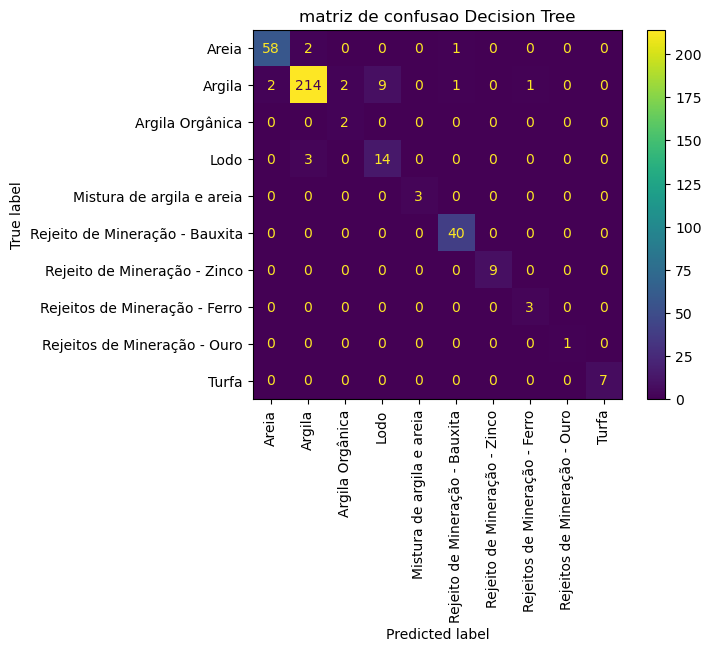

In [39]:
cm = model_confusion_matrix(DecisionTreeClassifier(random_state=0), smote=True)
plot_confusion_matrix(cm, "Decision Tree")

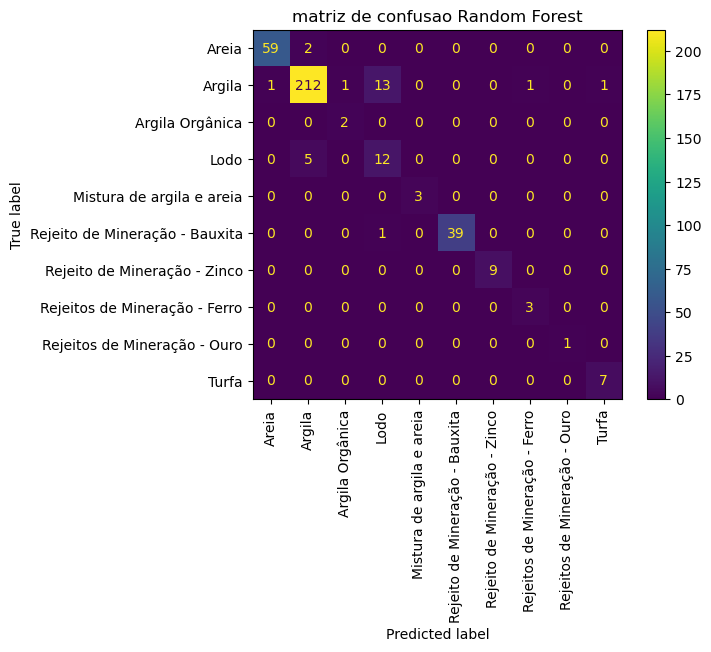

In [40]:
cm = model_confusion_matrix(RandomForestClassifier(random_state=0), smote=True)
plot_confusion_matrix(cm, "Random Forest")

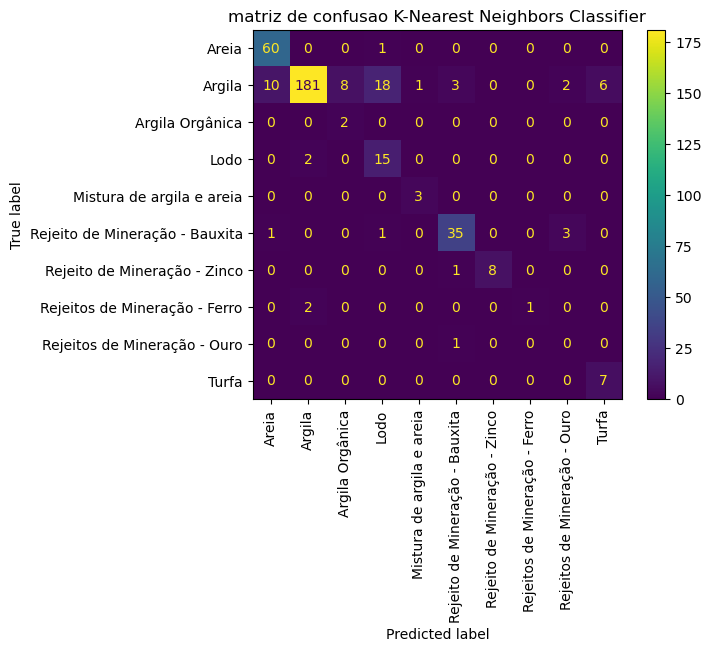

In [41]:
cm = model_confusion_matrix(KNeighborsClassifier(), smote=True)
plot_confusion_matrix(cm, "K-Nearest Neighbors Classifier")

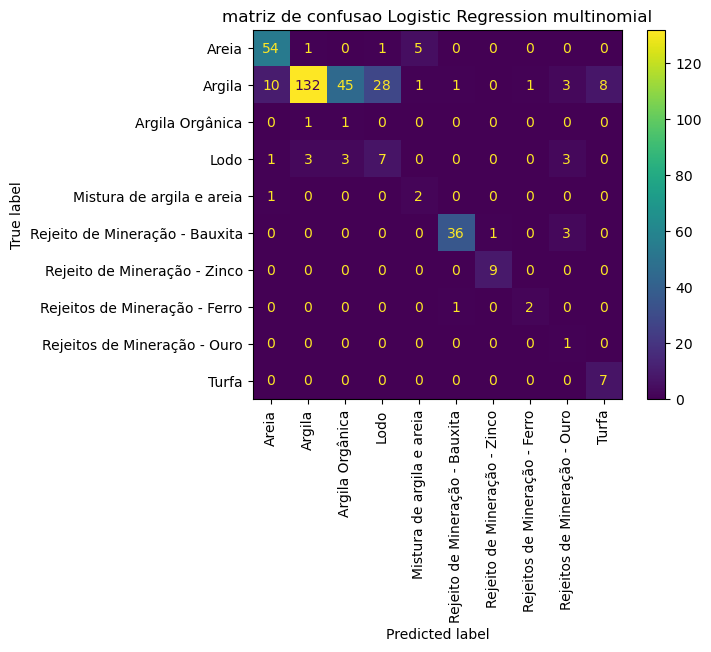

In [42]:
cm = model_confusion_matrix(LogisticRegression(random_state=0, max_iter=400, multi_class='multinomial'), smote=True)
plot_confusion_matrix(cm, "Logistic Regression multinomial")

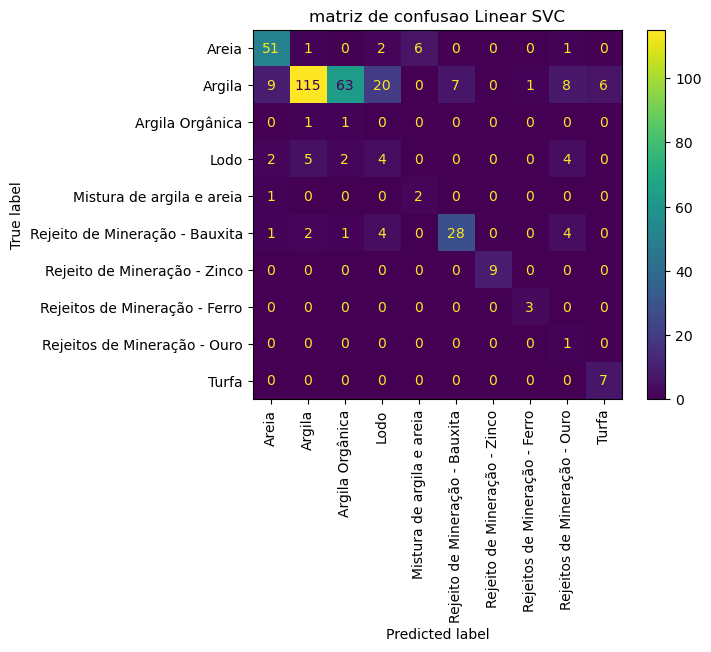

In [43]:
cm = model_confusion_matrix(LinearSVC(random_state=0), smote=True)
plot_confusion_matrix(cm, "Linear SVC")

# to do


- SMOTE
    - before or after scaling
- correlation of variables
- cross validation 
    - https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
    - https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
- one hot encoding (doesn't matter for algorithms used)
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer
    http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
- change size of training data and compare performance (to check for overfitting)
- see if other alternatives are better then yeo-johnson power transformer
- may be a good overall explanation https://scikit-learn.org/stable/user_guide.html#
- Time computation time
- fazer dicionário das palavras técnicas para o inglês português.
- descrever o q é o KDE? (kernel density estimate)



## not needed
- nomalize confusion_matrix in function model_confusion_matrix?
    - possible rules: The parameter normalize allows to report ratios instead of counts. The confusion matrix can be normalized in 3 different ways: 'pred', 'true', and 'all' which will divide the counts by the sum of each columns, rows, or the entire matrix, respectively. from https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix- nomalize confusion_matrix in function model_confusion_matrix?
    - possible rules: The parameter normalize allows to report ratios instead of counts. The confusion matrix can be normalized in 3 different ways: 'pred', 'true', and 'all' which will divide the counts by the sum of each columns, rows, or the entire matrix, respectively. from https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
- check algorithms to use
    - more on https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification
    use autogluton para pegar os q temmelhor resultado e os implementar manualmente.
    - lightGBM, ver se é fácil de explicar.- check algorithms to use
    - more on https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification
    use autogluton para pegar os q temmelhor resultado e os implementar manualmente.
    - lightGBM, ver se é fácil de explicar.

# questions

- too few sample of some labels
    - not balanced
    -is there something that can be done?
- do I need to split the dataset in training, test, and validation?
    - did I split well enough at 80% - 20%? some classes on the test dataset only have a few observations.
- does encoding the classes cause errors or bias? would it be better to do one-hot encoding (pode gerar erro nos lineares, ponderaçao arbitrária, usar one-hot encoding)
- should I study what each measurement means and it's scale?
    - is negative measument a valid result?
    - are they corelated?
- how to ensure if features are independent?
    - gráfico de correlção de variáveis,
    - scatter plot for correlations.
    - ou feature selection para selecionar as features mais importantes
- negative value for some variables
- should I make a scatter plot collor coded by class to better see if there is corelation between variables or classes?
    - boa idéa, fazer os 2 (junto com feature selection)

- is yeo-johnson a good power transformer to use for feature scaling? pode usar box-cox, dps de tirar negativos.
    - some variables have exponential distribution
    - alternative is taking log or sqrt of variable and then normalizing
    - can use different scaling methods for different features without affecting the result? I think yes, but make sure
- is confusion matrix in a good model? it can be normalized following the rules at:
    - possible rules: The parameter normalize allows to report ratios instead of counts. The confusion matrix can be normalized in 3 different ways: 'pred', 'true', and 'all' which will divide the counts by the sum of each columns, rows, or the entire matrix, respectively. from https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
    
- other classifications algorithms that should test:
    - more on https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification
- some linear models are stopping because it isn't converging, is there a problem? may it cause overfitting?
- should I time the execution time of each algorithm?
    - sim
    
matriz de confusão com todos os dados do dataset.


dados menos o g são feitos in situ (em campo) sem mandar para laboratório
- fazer analise sem o g, e ver a importância dele para predições
- vantagem para caracterizar o solo em campo.
-  correlação das features

usar autogun

trustee: (prov. não da tempo de usar)
- trustee arvore de decisao visual para verificar parametros usados para classificar o solo
- explicar a caixa preta dos modelos de machine learning

##rever TCC

###introdução

###Revisão teórica
- explicar passos
- analise do dataset
- comparação das escalas
- modelos de classificação
- confusion matrix

###3. PROCEDIMENTO METODOLÓGICO

Resultados

conclusão

trabalhos relacionados
- classificação com estabelecimento de limeares
- possível tema
    - Métodos de aprendizado de máquina para classificação de solos


### para imprimir tabelas bonitas e salvar pro excel
conda install -c anaconda jinja2 